# Image Segmentation

Some basic parameters:

In [1]:
VERSION = "C105c"

TESTRUN = True
#TESTRUN = False

In [2]:
#FIND_LR = False
FIND_LR = True

# Libraries

In [4]:
from fastai.vision.all import *
import pandas as pd
import gc # garbage collector
import glob
%matplotlib inline

# SemTorch
from semtorch import get_segmentation_learner

/home/ju/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [5]:
# fix randomness
my_seed = 42
np.random.seed(my_seed);random.seed(my_seed);set_seed(my_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Choose class used in this notebook

In [6]:
# what class are we looking for?
myclass = "reservoir"

# Dataset


In [7]:
root_dir = Path("../Data/")
root_dir

path = root_dir

Here we name the classes:

In [8]:
codes = np.array(['background', myclass])
codes

array(['background', 'reservoir'], dtype='<U10')

## Get data

We collect various training datasets into one dataframe. Some are excluded, as visual inspection showed that they are destroyed or otherwise unusable. Moreover, we extract their "overlap" from their file name. Overlap is available as a percentage value for each training image and indicates the percentage of overlap with the reservoir shape. Simply spoken, more overlap is better.

In [9]:
def excludeByList(df, excludeList):
    for e in excludeList:
        df = df[~df.fpath.str.contains('_'+str(e)+'_')]
    return df

In [10]:
# excludes some reservoirs (optional) and adds overlap column
def my_df_maker(path, excludeList=None):
    df = pd.DataFrame(glob.glob(str(path/'*.tif')), columns=['fpath'])
    if excludeList: df = excludeByList(df, excludeList)
    df["overlap"]= pd.to_numeric(df["fpath"].str.split("_").str[-4])
    return df

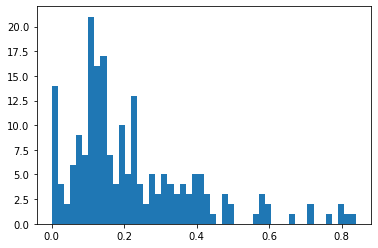

(201, 0.22113828516718168)

In [11]:
# images and masks
path_im = path/'TrainingData/Reservoirs_Sep10_zoom_19'
excludeList = [0,]

Reservoirs_Sep10 = my_df_maker(path_im, excludeList)

plt.hist(Reservoirs_Sep10['overlap'], bins=50);plt.show()
len(Reservoirs_Sep10), Reservoirs_Sep10['overlap'].mean()

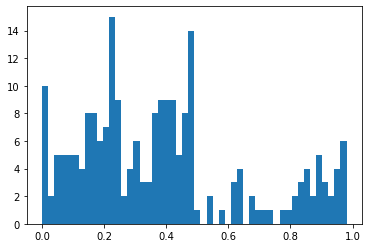

(218, 0.3868329226059286)

In [12]:
# images and masks
path_im = path/'TrainingData/Reservoirs_Sep26_zoom_19'
excludeList = [12,4,1,0]

Reservoirs_Sep26 = my_df_maker(path_im, excludeList)

plt.hist(Reservoirs_Sep26['overlap'], bins=50);plt.show()
len(Reservoirs_Sep26), Reservoirs_Sep26['overlap'].mean()

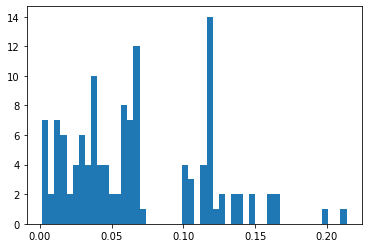

(128, 0.06655327479044593)

In [13]:
# images and masks
path_im = path/'TrainingData/Reservoirs_Dec05_zoom_19'
excludeList = []

Reservoirs_Dec05 = my_df_maker(path_im, excludeList)

plt.hist(Reservoirs_Dec05['overlap'], bins=50);plt.show()
len(Reservoirs_Dec05), Reservoirs_Dec05['overlap'].mean()

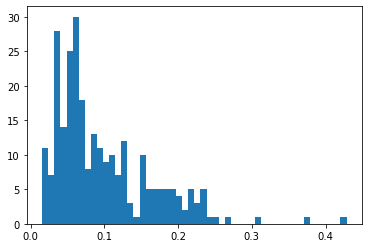

(267, 0.09801692700713462)

In [14]:
# images and masks
path_im = path/'TrainingData/Reservoirs_Feb02_zoom_19'
excludeList = [47,16,6,5,]

Reservoirs_Feb02 = my_df_maker(path_im, excludeList)

plt.hist(Reservoirs_Feb02['overlap'], bins=50);plt.show()
len(Reservoirs_Feb02), Reservoirs_Feb02['overlap'].mean()

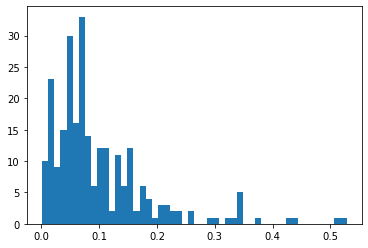

(250, 0.09928002929687497)

In [15]:
# images and masks
path_im = path/'TrainingData/Reservoirs_Feb10_zoom_19'
excludeList = [51,48,43,24,7]

Reservoirs_Feb10 = my_df_maker(path_im, excludeList)

plt.hist(Reservoirs_Feb10['overlap'], bins=50);plt.show()
len(Reservoirs_Feb10), Reservoirs_Feb10['overlap'].mean()

### Merge true-label datasets

In [16]:
# merge
mydf = pd.concat([Reservoirs_Sep10, 
                  Reservoirs_Sep26, 
                  #Reservoirs_Dec05, 
                  Reservoirs_Feb02, 
                  Reservoirs_Feb10,
                 ])
len(mydf)

936

We now filter out these with zero overlap

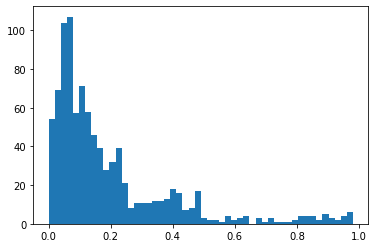

mean overlap : 0.1920607898310039


936

In [17]:
#  filter overlap. Here overlap greater 0
mydf = mydf[(mydf['overlap']>0) & (mydf['overlap']<=1)]

plt.hist(mydf['overlap'], bins=50);plt.show()
print("mean overlap :", mydf['overlap'].mean())
len(mydf)

In [18]:
# add mask path 
mydf['mask'] = mydf['fpath'].str.replace("Reservoirs_", "Masks_Reservoirs_")
mydf.head()

,fpath,overlap,mask
0,../Data/TrainingData/Reservoirs_Sep10_zoom_19/r_26_0.3443946838378906_103.75747737756863_13.626795496485432_19.tif,0.344395,../Data/TrainingData/Masks_Reservoirs_Sep10_zoom_19/r_26_0.3443946838378906_103.75747737756863_13.626795496485432_19.tif
1,../Data/TrainingData/Reservoirs_Sep10_zoom_19/r_6_0.11425399780273438_103.72232355964472_13.644556217750738_19.tif,0.114254,../Data/TrainingData/Masks_Reservoirs_Sep10_zoom_19/r_6_0.11425399780273438_103.72232355964472_13.644556217750738_19.tif
2,../Data/TrainingData/Reservoirs_Sep10_zoom_19/r_20_0.00766754150390625_103.71322944736538_13.668077434127744_19.tif,0.007668,../Data/TrainingData/Masks_Reservoirs_Sep10_zoom_19/r_20_0.00766754150390625_103.71322944736538_13.668077434127744_19.tif
3,../Data/TrainingData/Reservoirs_Sep10_zoom_19/r_24_0.12140655517578125_103.73636920574258_13.647259619448336_19.tif,0.121407,../Data/TrainingData/Masks_Reservoirs_Sep10_zoom_19/r_24_0.12140655517578125_103.73636920574258_13.647259619448336_19.tif
4,../Data/TrainingData/Reservoirs_Sep10_zoom_19/r_26_0.148773193359375_103.75548311763788_13.628087575193058_19.tif,0.148773,../Data/TrainingData/Masks_Reservoirs_Sep10_zoom_19/r_26_0.148773193359375_103.75548311763788_13.628087575193058_19.tif


### Add pseudo-labelled datasets

#### TestArea 3

In [19]:
# images and masks
path_im = path/'TrainingData/Reservoirs_TestArea3-edited_zoom_19'

Reservoirs_TestArea3 = pd.read_csv(path/'TrainingData/PredictedMasks_TestArea3-edited_zoom_19_C83_snippet.csv')
Reservoirs_TestArea3['fpath'] = Reservoirs_TestArea3['predicted'].\
    str.replace('PredictedMasks_TestArea3-edited_zoom_19','Reservoirs_TestArea3-edited_zoom_19').str.replace('reservoir','')
print ("Pseudo-labelled snippets :", len(Reservoirs_TestArea3))
print ("mean IoU :", Reservoirs_TestArea3['IoU'].mean())

Pseudo-labelled snippets : 3086
mean IoU : 0.16483776632303138


#### Filter overlap and IoU

In [20]:
IoUthresh = .38

In [21]:
Reservoirs_TestArea3 = Reservoirs_TestArea3[(Reservoirs_TestArea3['overlap']>0.) & (Reservoirs_TestArea3['overlap']<1.)]
print ("After filtered - overlap:", len(Reservoirs_TestArea3))
Reservoirs_TestArea3 = Reservoirs_TestArea3[Reservoirs_TestArea3['IoU']> IoUthresh]
print("After filtered - IoU:", len(Reservoirs_TestArea3))

After filtered - overlap: 3086
After filtered - IoU: 640


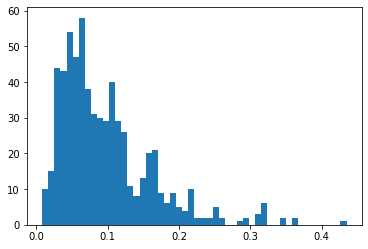

mean overlap : 0.09692085584004716


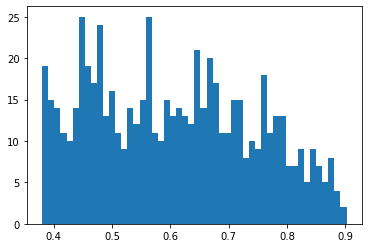

mean IoU : 0.6058050908920084


In [22]:
plt.hist(Reservoirs_TestArea3['overlap'], bins=50);plt.show()
print("mean overlap :", Reservoirs_TestArea3['overlap'].mean())
plt.hist(Reservoirs_TestArea3['IoU'], bins=50);plt.show()
print ("mean IoU :", Reservoirs_TestArea3['IoU'].mean())

##### Reservoirs 4000

In [23]:
# images and masks
path_im = path/'TrainingData/Reservoirs_4000_zoom_19'

Reservoirs_4000 = pd.read_csv(path/'TrainingData/PredictedMasks_4000_zoom_19_C83_snippet.csv')
Reservoirs_4000['fpath'] = Reservoirs_4000['predicted'].\
    str.replace('PredictedMasks_4000_zoom_19','Reservoirs_4000_zoom_19').str.replace('reservoir','')
print ("Pseudo-labelled snippets :", len(Reservoirs_4000))
print ("mean IoU :", Reservoirs_4000['IoU'].mean())

Pseudo-labelled snippets : 4590
mean IoU : 0.03627444632089139


#### Filter overlap and IoU

In [24]:
IoUthresh = .38

In [25]:
Reservoirs_4000 = Reservoirs_4000[(Reservoirs_4000['overlap']>0) & (Reservoirs_4000['overlap']<1.)]
print ("After filtered - overlap:", len(Reservoirs_4000))
Reservoirs_4000 = Reservoirs_4000[Reservoirs_4000['IoU']> IoUthresh]
print("After filtered - IoU:", len(Reservoirs_4000))

After filtered - overlap: 4590
After filtered - IoU: 138


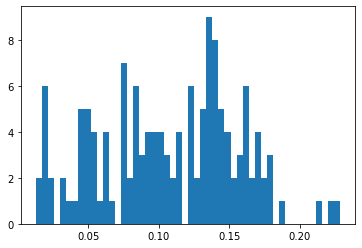

mean overlap : 0.10728285969167511


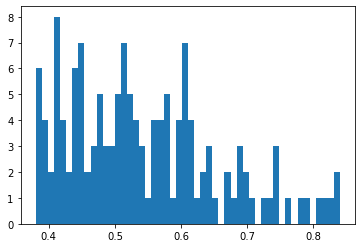

mean IoU : 0.5430203445563457


In [26]:
plt.hist(Reservoirs_4000['overlap'], bins=50);plt.show()
print("mean overlap :", Reservoirs_4000['overlap'].mean())
plt.hist(Reservoirs_4000['IoU'], bins=50);plt.show()
print ("mean IoU :", Reservoirs_4000['IoU'].mean())

### Merge all

In [27]:
# use original masks
MASKPREFIX = "Masks_Reservoirs_"
# use predicted masks
MASKPREFIX = "PredictedMasks_"

In [28]:
# add mask path 
Reservoirs_TestArea3['mask'] = Reservoirs_TestArea3['fpath'].str.replace("Reservoirs_", MASKPREFIX)
Reservoirs_4000['mask']      = Reservoirs_4000['fpath'].str.replace("Reservoirs_", MASKPREFIX)

In [29]:
# merge
mydf = pd.concat([mydf,
                  mydf, mydf, #oversample!
                  Reservoirs_TestArea3,
                  Reservoirs_4000,
                 ])
len(mydf)

3586

### Filter (almost) empty data

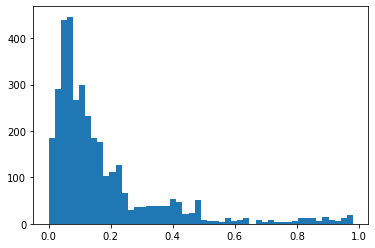

In [30]:
plt.hist(mydf["overlap"], bins=50)
plt.show()

In [31]:
# 0 means zero empty snippets
mysample = 0#200 # was 100
keep = mydf[mydf["overlap"]==0].sample(mysample)

In [32]:
# drop the (almost) empty ones
#mydf = mydf[mydf["overlap"]>min_coverage]

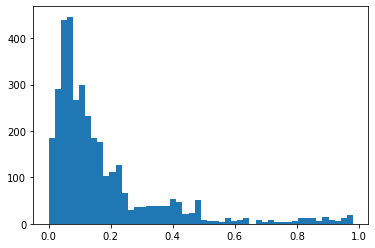

In [33]:
plt.hist(mydf["overlap"], bins=50)
plt.show()

In [34]:
# merge
mydf = pd.concat([mydf, keep])
len(mydf)

3586

### Final distribution

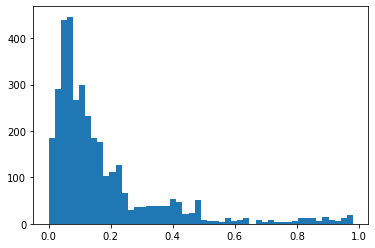

mean overlap : 0.17181848305090358


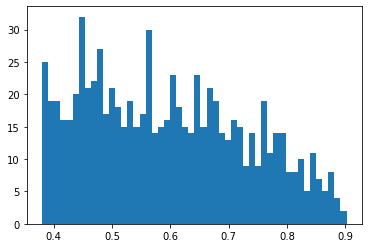

mean IoU : 0.594668464935297


In [35]:
plt.hist(mydf['overlap'], bins=50);plt.show()
print("mean overlap :", mydf['overlap'].mean())
plt.hist(mydf['IoU'], bins=50);plt.show()
print ("mean IoU :", mydf['IoU'].mean())

In [36]:
# shuffle dataframe, just in case!
mydf = mydf.sample(frac=1).reset_index(drop=True)

## Progressive resizing

In the first round we will train at half the image size. In our case it is actually half of half, as this got us better regularization.

In [37]:
sz = (512//2,512//2);sz

(256, 256)

In [38]:
half = tuple(int(x/2) for x in sz); half

(128, 128)

## Augmentation transforms

In [41]:
def my_transforms(imgsize):
    item_tfms = [Resize(imgsize[0])]
    batch_tfms = [Dihedral(),Brightness(0.1,p=0.25), Zoom(max_zoom=1.1,p=0.25),
                  RandomErasing(p=0.5, sl=0.0, sh=0.2, min_aspect=0.3, max_count=6),
                  Normalize.from_stats(*imagenet_stats)]
    return item_tfms, batch_tfms

In [42]:
# test augmentation transforms
#item_tfms, batch_tfms = my_transforms((512,512))
#batch_tfms

### Mask retrieval function for dataframe rows

In [43]:
# modified from https://walkwithfastai.com/Binary_Segmentation
myemptymask = np.zeros(sz, dtype=np.int8)

def get_msk(row):
    #fn = Path(row["mask"])
    fn = row["mask"]
    pix = np.array(PILMask.create(fn))
    if 'Predicted' in fn:
        pix[pix<128]  = 0 # background
        pix[pix>=128] = 1 # foreground
    else:
        pix[pix>0] = 1 # foreground = all that is not 0
    
    return PILMask.create(pix)

### Dataloaders

In [44]:
# function for retrieving a dataloaders object for a 'fold'
# TODO: arbitrary percentage for train/valid split. Currently 1/n_splits
def get_data(mydf, fold, n_splits, codes, bs, item_tfms, batch_tfms):
    length = int(len(mydf)/n_splits)
    start = fold*length
    
    # this adds an 'is_valid' column
    mydf['is_valid'] = False
    mydf.loc[start:start+length,'is_valid'] = True
    # the datablock   
    dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes=codes)),
                   #splitter=RandomSplitter(valid_pct=0.2),
                   splitter=ColSplitter(), #!!! is_valid is in valid_ds
                   get_x=ColReader('fpath'),
                   get_y=get_msk, item_tfms=item_tfms, batch_tfms=batch_tfms)
    # the dataloaders
    dls = dblock.dataloaders(mydf, path='', bs=bs)
    return dls

## Model: DeeplabV3+ with ResNet101

In [45]:
# optimizer: we use Ranger instead of Adam
opt = ranger

In [46]:
# we use IoU as metric, which is the same as Jaccard.
metrics = [JaccardCoeff()]

### Class imbalance

The dataset is probably imbalanced with only some N percent% of all pixels containing mask data ("1"). We use a combined loss of focal and dice loss

In [50]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [53]:
myloss_func=CombinedLoss()

In [54]:
def segmentron_splitter(model):
    return [params(model.backbone), params(model.head)]

### Architecture and backbone


In [55]:
#arch="hrnet";backbone="hrnet_w30"

arch="deeplabv3+";backbone="resnet101"
#arch="deeplabv3+";backbone="resnet50"
#arch="deeplabv3+";backbone="resnet18"
    
arch, backbone

('deeplabv3+', 'resnet101')

In [56]:
# these callbacks are used during training. The first three monitor training progress, Cutmix is for augmentation.
callbacks = [SaveModelCallback(monitor='jaccard_coeff'), 
             EarlyStoppingCallback(monitor='jaccard_coeff', patience=8),
             ReduceLROnPlateau(monitor='jaccard_coeff'),
             #MixUp(),
             #CutMix()
            ]

## we should try Mixup and CutMix

In [57]:
# we use the flat cosine annealing training loop along with fastai's default fine_tune(), so we create
# our own fine_tune_flat(), modelled after Zachary Mueller's notebook from here: 
# https://www.kaggle.com/muellerzr/cassava-fastai-starter

@patch
def fine_tune_flat(self:Learner, epochs, base_lr=4e-3, freeze_epochs=1, lr_mult=100, pct_start=0.75, 
                   first_callbacks = [], second_callbacks = [], tofp32=False,**kwargs):
    "Fine-tune applied to `fit_flat_cos`"
    self.freeze()
    self.fit_flat_cos(freeze_epochs, slice(base_lr), pct_start=0.99, cbs=first_callbacks, **kwargs)
    gc.collect();torch.cuda.empty_cache()
    base_lr /= 2
    self.unfreeze()
    if tofp32: self.to_fp32() # set to 32 bit
    self.fit_flat_cos(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, cbs=second_callbacks)
    gc.collect();torch.cuda.empty_cache()

### k-fold loop:

In [58]:
n_folds = 5

we have two training cycles, one with half size images, one with full size images:

## half size training cycle

In [1]:
size = half

NameError: name 'half' is not defined

In [60]:
#  batch size
if arch=="deeplabv3+":
    bs = 28#20 
else:
    bs = 30


28

In [59]:
# define augmentation transforms
item_tfms, batch_tfms = my_transforms(size)

/home/ju/miniconda3/envs/fastai/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


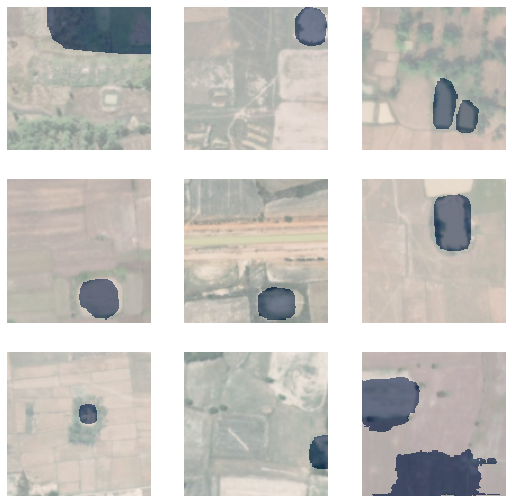

In [60]:
dls = get_data(mydf, 0, n_folds, codes, bs, item_tfms, batch_tfms) # get the dataloaders
dls.show_batch(cmap='Blues', vmin=0, vmax=1)

/home/ju/miniconda3/envs/fastai/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


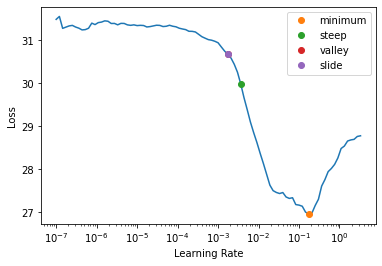

In [61]:
if FIND_LR:
    dls = get_data(mydf, 0, n_folds, codes, bs, item_tfms, batch_tfms) # get the dataloaders
    learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                     architecture_name=arch, backbone_name=backbone, metrics=metrics,
                                     splitter=segmentron_splitter, opt_func=opt,

                                     wd=1e-1, # weight decay

                                     loss_func=myloss_func).to_fp16() # we use fp16 training
    lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [62]:
if FIND_LR: print (lrs)

SuggestedLRs(minimum=0.017378008365631102, steep=0.00363078061491251, valley=0.001737800776027143, slide=0.001737800776027143)


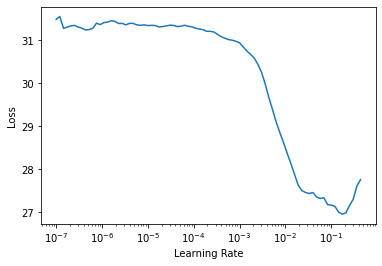

In [63]:
if FIND_LR: 
    learn.recorder.plot_lr_find(skip_end=16)
    del dls, learn # garbage collect

In [64]:
#set hyperparameters:
lr = lrs.valley #1e-2
#lr = 1e-2
freeze_epochs = 2#3
epochs = 26#20#16

lr, epochs

(0.001737800776027143, 26)

--- fold # 0


/home/ju/miniconda3/envs/fastai/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,jaccard_coeff,time
0,19.649164,16.025089,0.515550,00:33
1,14.819434,11.821700,0.642245,00:34


Better model found at epoch 0 with jaccard_coeff value: 0.5155501072755487.
Better model found at epoch 1 with jaccard_coeff value: 0.6422448689323851.


epoch,train_loss,valid_loss,jaccard_coeff,time
0,12.080402,10.093364,0.690251,00:35
1,10.911498,8.819790,0.740217,00:37
2,10.179201,8.436363,0.742446,00:38
3,9.594023,7.325897,0.780904,00:36
4,9.083470,7.736342,0.758545,00:39
5,8.521189,6.346504,0.815716,00:37
6,8.249977,6.422299,0.817591,00:36
7,8.004085,5.856113,0.834590,00:37
8,7.501059,6.022212,0.827001,00:35
9,7.349665,5.767797,0.835580,00:36


Better model found at epoch 0 with jaccard_coeff value: 0.6902508006865737.
Better model found at epoch 1 with jaccard_coeff value: 0.740217395511793.
Better model found at epoch 2 with jaccard_coeff value: 0.7424458823651244.
Better model found at epoch 3 with jaccard_coeff value: 0.780903675494375.
Epoch 4: reducing lr to 8.689003880135714e-05
Better model found at epoch 5 with jaccard_coeff value: 0.8157160299218613.
Better model found at epoch 6 with jaccard_coeff value: 0.81759066405155.
Better model found at epoch 7 with jaccard_coeff value: 0.8345898069370156.
Epoch 8: reducing lr to 8.689003880135714e-05
Better model found at epoch 9 with jaccard_coeff value: 0.8355801903536356.
Better model found at epoch 10 with jaccard_coeff value: 0.8523860361586179.
Epoch 11: reducing lr to 8.689003880135714e-05
Better model found at epoch 12 with jaccard_coeff value: 0.8584289344107867.
Epoch 13: reducing lr to 8.689003880135714e-05
Better model found at epoch 14 with jaccard_coeff value:

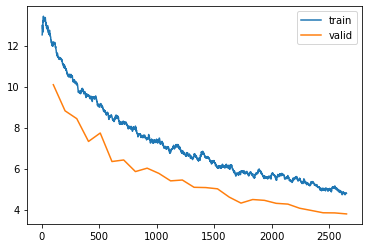

In [65]:
for fold in range(n_folds):
    print ("--- fold #", fold)
    dls = get_data(mydf, fold, n_folds, codes, bs, item_tfms, batch_tfms) # get the dataloaders
    # here we create the segmentation learner with SemTorch. The models are all pre-trained on ImageNet
    learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name=arch, backbone_name=backbone,
                                 metrics=metrics, splitter=segmentron_splitter, opt_func=opt, 
                                     
                                 wd=1e-1,
                            
                                 loss_func=myloss_func).to_fp16() # we use fp16 training
    # here is the training cycle: we train for 'freeze_epochs' with all layers (except the last) frozen,
    # then we train for 'epochs' with all layers unfrozen
    learn.fine_tune_flat(epochs, lr, freeze_epochs, first_callbacks=callbacks, second_callbacks=callbacks)
    learn.recorder.plot_loss()
    learn.to_fp32() # needed?
    learn.export('models/stage-1_'+arch+'_'+VERSION+'_'+myclass+str(fold))
    print ("--- fold complete #", fold)
    print ("-----------------")
    del dls#, learn # free memory
    if TESTRUN: break # leave after first fold
    
# beat .55-.60

/home/ju/miniconda3/envs/fastai/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


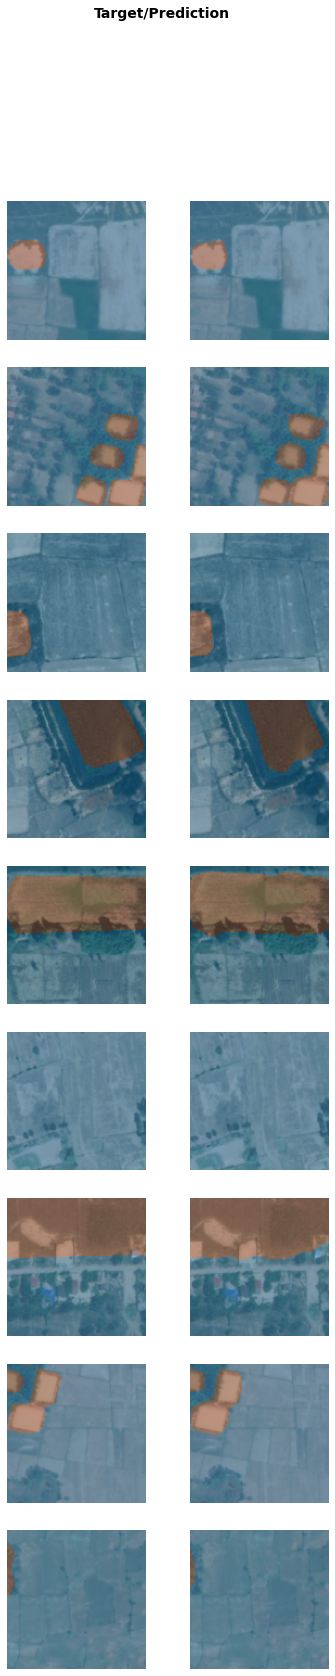

In [66]:
learn.show_results()

In [68]:
MYMODEL = "models/m_"+arch+'_'+VERSION+"_"+myclass+str(fold)+".pkl"
print (MYMODEL)
print ("--- fold complete #", fold)
print ("-----------------")
learn.export(MYMODEL)


models/m_deeplabv3+_C105c_reservoir0.pkl
--- fold complete # 0
-----------------


## Full size training cycle

In [62]:
size=sz

In [63]:
# sz is full size now, so we need new transforms
item_tfms, batch_tfms = my_transforms(size)

In [64]:
# reduce the batch size
if arch=="deeplabv3+":
    bs = 10#12
else:
    bs = 12

if JARVIS:
    if arch=="deeplabv3+":
        bs = 12 # 2 for Unet
    else:
        bs = 16
bs

10

/home/ju/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


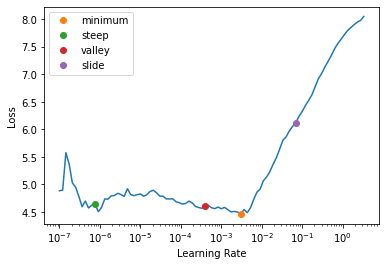

In [65]:
if FIND_LR:
    dls = get_data(mydf, 0, n_folds, codes, bs, item_tfms, batch_tfms) # get dataloaders
    learn = load_learner('models/stage-1_'+arch+'_'+VERSION+'_'+myclass+str(0)) # re-load the learner
    learn.dls = dls # and insert the new dataloaders
    learn.to_fp16() # switch into fp16 training (half precision)
    learn.loss_func = myloss_func # set loss function
    lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [66]:
if FIND_LR: print (lrs)

SuggestedLRs(minimum=0.0003019951749593019, steep=7.585775847473997e-07, valley=0.0003981071640737355, slide=0.0691830962896347)


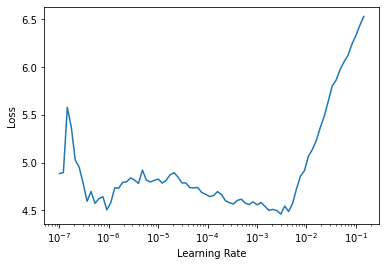

In [67]:
if FIND_LR: learn.recorder.plot_lr_find(skip_end=22)

In [68]:
if FIND_LR: del dls, learn # garbage collect

In [69]:
# set hyperparameters
lr = lrs.valley #0.02
#lr = 7e-5
freeze_epochs = 3
if arch=="deeplabv3+":
    epochs = 42#28
else:
    epochs = 28

lr, epochs

(0.0003981071640737355, 42)

--- fold # 0


/home/ju/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,jaccard_coeff,time
0,3.765994,2.604519,0.794559,00:53
1,3.216515,2.345735,0.812617,00:56
2,3.078444,2.038277,0.838250,00:56


Better model found at epoch 0 with jaccard_coeff value: 0.7945590745283851.
Better model found at epoch 1 with jaccard_coeff value: 0.8126167690749592.
Better model found at epoch 2 with jaccard_coeff value: 0.8382497983595419.


epoch,train_loss,valid_loss,jaccard_coeff,time
0,2.632366,1.912034,0.851846,02:01
1,2.668860,1.910773,0.849663,02:00
2,2.495130,1.851171,0.860867,01:58
3,2.383598,1.750436,0.871937,01:59
4,2.321429,1.672939,0.872299,02:00
5,2.129944,1.726323,0.878208,01:59
6,2.072587,1.566445,0.886001,01:58
7,2.206886,1.577310,0.883757,01:59
8,2.112070,1.537985,0.888397,01:58
9,2.050634,1.465444,0.894452,01:59


Better model found at epoch 0 with jaccard_coeff value: 0.8518457254861732.
Epoch 1: reducing lr to 1.9905358203686774e-05
Better model found at epoch 2 with jaccard_coeff value: 0.8608670560169329.
Better model found at epoch 3 with jaccard_coeff value: 0.8719374872464193.
Better model found at epoch 4 with jaccard_coeff value: 0.8722990183387392.
Better model found at epoch 5 with jaccard_coeff value: 0.8782080635786749.
Better model found at epoch 6 with jaccard_coeff value: 0.8860007838529946.
Epoch 7: reducing lr to 1.9905358203686774e-05
Better model found at epoch 8 with jaccard_coeff value: 0.8883967387801013.
Better model found at epoch 9 with jaccard_coeff value: 0.8944519415511137.
Epoch 10: reducing lr to 1.9905358203686774e-05
Epoch 11: reducing lr to 1.9905358203686774e-05
Epoch 12: reducing lr to 1.9905358203686774e-05
Epoch 13: reducing lr to 1.9905358203686774e-05
Epoch 14: reducing lr to 1.9905358203686774e-05
Better model found at epoch 15 with jaccard_coeff value: 0

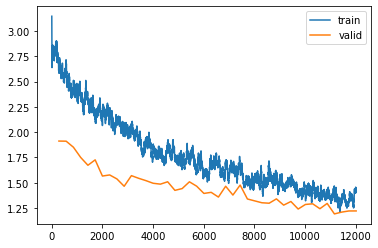

In [70]:
# we iterate over each fold
for fold in range(n_folds):
    print ("--- fold #", fold)
    dls = get_data(mydf, fold, n_folds, codes, bs, item_tfms, batch_tfms) # get dataloaders
    learn = load_learner('models/stage-1_'+arch+'_'+VERSION+'_'+myclass+str(fold)) # re-load the learner
    learn.dls = dls # and insert the new dataloaders
    learn.to_fp16() # switch into fp16 training (half precision)
    learn.loss_func = myloss_func # set loss function
    # note that we now fine tune again but 2nd cycle with full precision (tofp32)
    learn.fine_tune_flat(epochs, lr, freeze_epochs, first_callbacks=callbacks, second_callbacks=callbacks, 
                         tofp32=True)
    learn.recorder.plot_loss()
    MYMODEL = "models/m_"+arch+'_'+VERSION+"_"+myclass+str(fold)+".pkl"
    print (MYMODEL)
    print ("--- fold complete #", fold)
    print ("-----------------")
    learn.export(MYMODEL)
    del dls#, learn
    if TESTRUN: break
        
# beat .702

/home/ju/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


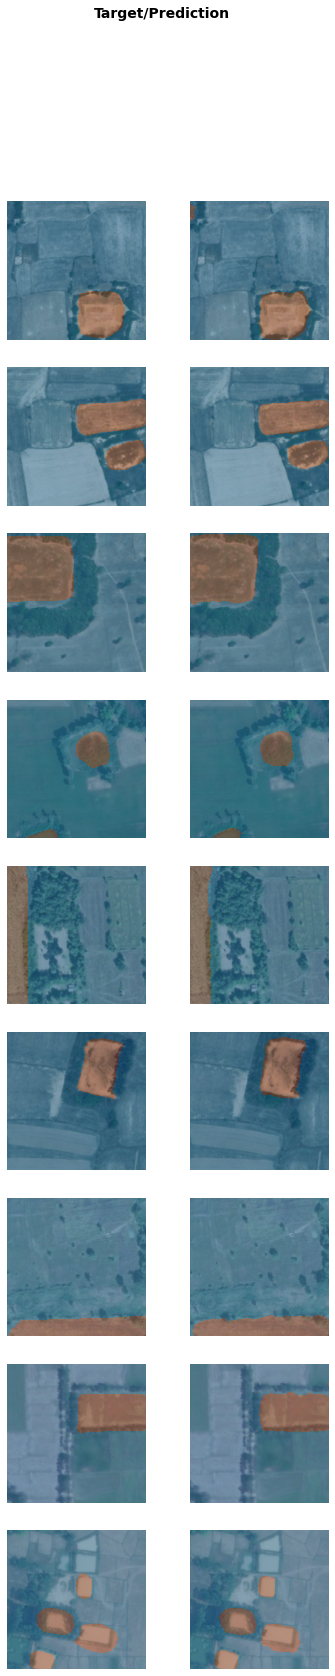

In [71]:
learn.show_results()

# END